In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

np.random.seed(0)

In [61]:
os.getcwd()
train = pd.read_csv('C:\\Users\\chris\\Desktop\\210\\W210-Capstone\\data\\TrainingData\\trainingWithItems.csv')

In [127]:
train.head()

,Unnamed: 0,YEAR FORECAST MADE,QUARTER,YEAR BEING FORECAST,INDICATOR,FORECASTER ID,INDUSTRY,Year.ID.ForecastYear.Quarter,Indicator.Year.ID.ForecastYear.Quarter,BIN 1,...,ACTUAL_CONF,HIT,pred_average,pred_var,chicken,coffee,eggs,electricity,rice,unleadedGasoline
0,0,1968,4,1968,NominalGNP,1,NaN,1968-1-1968-4,NominalGNP-1968-1-1968-4,0.0,...,0.00,0.0,6.00,0.4500,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1968,4,1968,NominalGNP,2,NaN,1968-2-1968-4,NominalGNP-1968-2-1968-4,0.0,...,0.00,0.0,6.10,1.0400,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1968,4,1968,NominalGNP,3,NaN,1968-3-1968-4,NominalGNP-1968-3-1968-4,0.0,...,0.00,0.0,6.80,0.4100,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1968,4,1968,NominalGNP,4,NaN,1968-4-1968-4,NominalGNP-1968-4-1968-4,0.0,...,0.00,0.0,6.15,1.3275,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1968,4,1968,NominalGNP,5,NaN,1968-5-1968-4,NominalGNP-1968-5-1968-4,3.0,...,0.04,0.0,4.65,7.2275,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
unemp = train[train['INDICATOR'] == "Unemployment"]
rgdp = train[train['INDICATOR'] == "RealGDP"]
cpce = train[train['INDICATOR'] == "Core PCE"]
ccpi = train[train['INDICATOR'] == "Core CPI"]
ngnp = train[train['INDICATOR'] == "NominalGNP"]
rgnp = train[train['INDICATOR'] == "RealGNP"]

In [131]:
np.random.seed(0)
def model_setup(df):
    
    rand = df.sample(frac = 1)
    #80/20 split
    nrow = len(rand)
    train_prop = int(np.round(nrow*0.8))
    train = rand[:train_prop]
    val = rand[train_prop:]
    
    train = train[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF", "actual",
                  "chicken", "coffee", "eggs", "electricity", "rice", "unleadedGasoline"]]
    val = val[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF", "actual",
              "chicken", "coffee", "eggs", "electricity", "rice", "unleadedGasoline"]]
    
    return train.dropna(), val.dropna()

In [158]:
def run_model(df, variable_name, model, plot=True, ensemble=False):
    
    """model can be "LM" or "RF" for linear model or random forest"""
    
    train, val = model_setup(df)
    X_train, Y_train = train[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF",
                             "chicken", "coffee", "eggs", "electricity", "rice", "unleadedGasoline"]], train["actual"].tolist()
    X_val, Y_val = val[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF",
                       "chicken", "coffee", "eggs", "electricity", "rice", "unleadedGasoline"]], val["actual"].tolist()
    
    if ensemble == True:
        lr = LinearRegression()
        fitted = lr.fit(X_train, Y_train)
        preds_lm = fitted.predict(X_val)
        preds_lm = preds_lm.flatten()
        
        rf = RandomForestRegressor()
        fitted = rf.fit(X_train, Y_train)
        
        model=xgb.XGBRegressor(verbosity=0)
        fitted = model.fit(X_train, Y_train)
        preds_xg = model.predict(X_val)

        preds_rf = []
        for i in range(len(Y_val)):
            row = X_val.iloc[[i]].values.tolist()
            pred = rf.predict(row)
            pred = pred.flatten()[0]
            preds_rf.append(pred)
            
        preds = [np.mean(val) for val in zip(preds_lm, preds_rf, preds_xg)]
        
    else:
        if model == "LM":
            lr = LinearRegression()
            fitted = lr.fit(X_train, Y_train)
            preds = fitted.predict(X_val)
            preds = preds.flatten()

        elif model == "RF":
            rf = RandomForestRegressor()
            fitted = rf.fit(X_train, Y_train)

            preds = []
            for i in range(len(Y_val)):
                row = X_val.iloc[[i]].values.tolist()
                pred = rf.predict(row)
                pred = pred.flatten()[0]
                preds.append(pred)
                
        elif model == "XG":
            model=xgb.XGBRegressor(verbosity=0)
            fitted = model.fit(X_train, Y_train)
            preds = model.predict(X_val)

        else:
            print("Please select a different model.")
            return
    
    diffs = np.subtract(Y_val, preds)

    r2_pred = np.corrcoef(Y_val, preds)[0][1]
    r2_actual = np.corrcoef(Y_val, np.array(X_val['pred_average'].tolist()))[0][1]
    
    rmse_pred = np.sqrt(mean_squared_error(Y_val, preds))
    rmse_actual = np.sqrt(mean_squared_error(Y_val, np.array(X_val['pred_average'].tolist())))
    
    if plot == True:
        print("Differences in actual vs. model prediction (" + variable_name + ")")
        print("Mean: " + str(np.mean(diffs)))
        print("Median: " + str(np.median(diffs)))
        print("Max: " + str(max(diffs)))
        print("Min: " + str(min(diffs)))
        print("Correlation Coef: " + str(r2_pred))
        print("RMSE: " + str(rmse_pred))

        plt.hist(diffs)
        plt.title("Actual minus Model Prediction (" + variable_name + ")")
        plt.show()

        actual_diffs = np.subtract(Y_val, np.array(X_val['pred_average'].tolist()))
        print("Differences in actual vs. forecaster average prediction (" + variable_name + ")")
        print("Mean: " + str(np.mean(actual_diffs)))
        print("Median: " + str(np.median(actual_diffs)))
        print("Max: " + str(max(actual_diffs)))
        print("Min: " + str(min(actual_diffs)))
        print("Correlation Coef: " + str(r2_actual))
        print("RMSE: " + str(rmse_actual))

        plt.hist(actual_diffs)
        plt.title("Actual Rate minus Forecaster Average Prediction (" + variable_name + ")")
        plt.show()
        
    else:
        return rmse_pred, rmse_actual, r2_pred, r2_actual

In [129]:
def get_preds(df, model):
    
    """model can be "LM" or "RF" for linear model or random forest
       returns the actual, model predicted, and forecaster predicted for that model/economics measure
    """
    
    train, val = model_setup(df)
    X_train, Y_train = train[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF",
                             "chicken", "coffee", "eggs", "electricity", "rice", "unleadedGasoline"]], train["actual"].tolist()
    X_val, Y_val = val[["FORECASTER ID", "MAX", "pred_average", "pred_var", "HIT", "ACTUAL_CONF",
                       "chicken", "coffee", "eggs", "electricity", "rice", "unleadedGasoline"]], val["actual"].tolist()
    
    if model == "LM":
        lr = LinearRegression()
        fitted = lr.fit(X_train, Y_train)
        preds = fitted.predict(X_val)
        preds = preds.flatten()
        
    elif model == "RF":
        rf = RandomForestRegressor()
        fitted = rf.fit(X_train, Y_train)

        preds = []
        for i in range(len(Y_val)):
            row = X_val.iloc[[i]].values.tolist()
            pred = rf.predict(row)
            pred = pred.flatten()[0]
            preds.append(pred)
            
    else:
        print("Please select a different model.")
        return
    
    return X_val, Y_val, pred

In [142]:
def evaluate(model):
    rmse1s = []
    rmse2s = []
    r21s = []
    r22s = []
    names = ["Unemployment", "Real GDP", "Core PCE", "Core CPI"]
    dfs = [unemp, rgdp, cpce, ccpi]
    for i in range(len(dfs)):
        rmse1, rmse2, r21, r22 = run_model(dfs[i], "name", model, plot=False)
        rmse1s.append(rmse1)
        rmse2s.append(rmse2)
        r21s.append(r21)
        r22s.append(r22)
        print(names[i])
        print(rmse1, rmse2, r21, r22)
        print()
        
    rmse_diff = np.mean(np.subtract(rmse2s,rmse1s))
    r2_diff = np.mean(np.subtract(r21s, r22s))
    
    print("We decrease RMSE by " + str(rmse_diff))
    print("We increase R-squared by " + str(r2_diff))
    
    #return rmse1s, rmsess, r21s, r22s

In [147]:
def evaluate_ensemble():
    rmse1s = []
    rmse2s = []
    r21s = []
    r22s = []
    names = ["Unemployment", "Real GDP", "Core PCE", "Core CPI"]
    dfs = [unemp, rgdp, cpce, ccpi]
    for i in range(len(dfs)):
        rmse1, rmse2, r21, r22 = run_model(dfs[i], "name", "LM", plot=False, ensemble=True)
        rmse1s.append(rmse1)
        rmse2s.append(rmse2)
        r21s.append(r21)
        r22s.append(r22)
        print(names[i])
        print(rmse1, rmse2, r21, r22)
        print()
        
    rmse_diff = np.mean(np.subtract(rmse2s,rmse1s))
    r2_diff = np.mean(np.subtract(r21s, r22s))
    
    print("We decrease RMSE by " + str(rmse_diff))
    print("We increase R-squared by " + str(r2_diff))
    
    #return rmse1s, rmse2s, r21s, r22s

# Linear Regression

### Unemployment

Differences in actual vs. model prediction (Unemployment)
Mean: -0.1251444764087436
Median: 0.20529560148101478
Max: 6.85234194992708
Min: -7.17145913339471
Correlation Coef: 0.6784085426838877
RMSE: 2.111294240899633


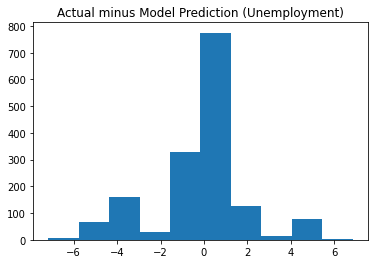

Differences in actual vs. forecaster average prediction (Unemployment)
Mean: -1.0486688786646037
Median: -0.6326126399126251
Max: 7.28333333333333
Min: -7.85
Correlation Coef: 0.6527027422763371
RMSE: 2.410424114046406


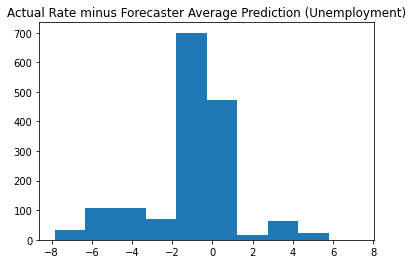

In [87]:
run_model(unemp, "Unemployment", "LM", plot = True)

### Real GDP

Differences in actual vs. model prediction (Real GDP)
Mean: 0.007831027307495771
Median: 0.038458297049159595
Max: 4.365659285769476
Min: -7.523480816009251
Correlation Coef: 0.6055716928571496
RMSE: 1.4865919626250528


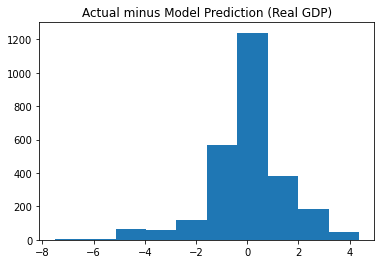

Differences in actual vs. forecaster average prediction (Real GDP)
Mean: -0.4499737041036553
Median: -0.20306500000000005
Max: 3.70324
Min: -7.57376
Correlation Coef: 0.5333098587682804
RMSE: 1.643381354579117


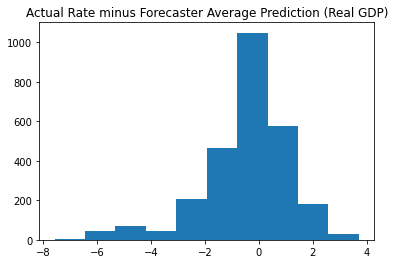

In [88]:
run_model(rgdp, "Real GDP", "LM", plot=True)

### Core PCE

Differences in actual vs. model prediction (Core PCE)
Mean: 0.009011527990146616
Median: -0.1359294428864799
Max: 6.371452804488813
Min: -1.9759611578211713
Correlation Coef: 0.07697877076398316
RMSE: 1.2174383258602164


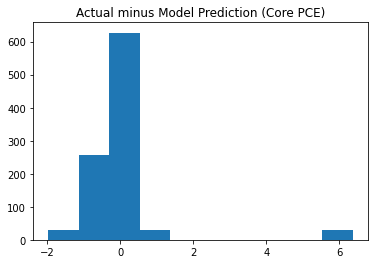

Differences in actual vs. forecaster average prediction (Core PCE)
Mean: -0.05154847312459374
Median: -0.17810805484746006
Max: 7.358333
Min: -2.85
Correlation Coef: 0.022225592335442364
RMSE: 1.2901135498525942


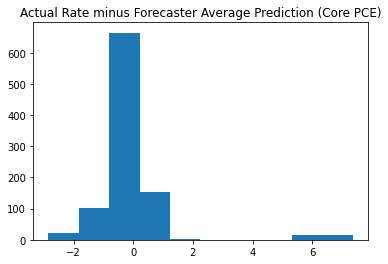

In [89]:
run_model(cpce, "Core PCE", "LM", plot=True)

### Core CPI

Differences in actual vs. model prediction (Core CPI)
Mean: -0.00876333380078843
Median: -0.08565511184134889
Max: 6.302206194840204
Min: -2.2811708513905
Correlation Coef: 0.09290685800648438
RMSE: 1.2196359915755413


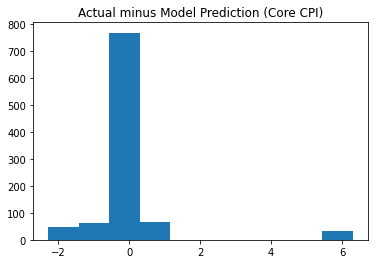

Differences in actual vs. forecaster average prediction (Core CPI)
Mean: 0.0036721104765551162
Median: -0.10442747353666604
Max: 8.008333
Min: -4.29380034612723
Correlation Coef: 0.04899231624101068
RMSE: 1.3288383911563013


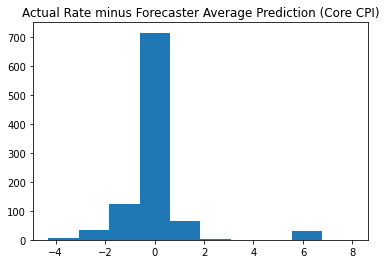

In [90]:
run_model(ccpi, "Core CPI", "LM", plot=True)

### Nominal GNP

Differences in actual vs. model prediction (Nominal GNP)
Mean: -0.04880222522515166
Median: 0.03413358163926361
Max: 6.202904553375824
Min: -4.564786936549464
Correlation Coef: 0.7206398800825808
RMSE: 1.4146400990381125


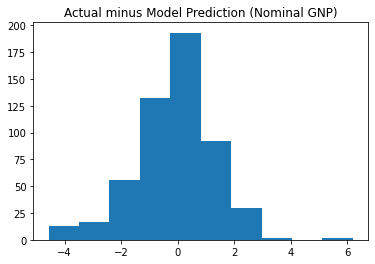

Differences in actual vs. forecaster average prediction (Nominal GNP)
Mean: 1.1144252624592066
Median: 0.8078699999999994
Max: 10.97415
Min: -4.01285
Correlation Coef: 0.6837811524931326
RMSE: 2.1929177836500116


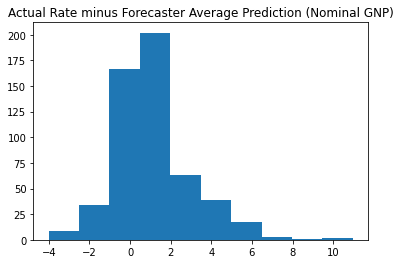

In [91]:
run_model(ngnp, "Nominal GNP", "LM", plot=True)

### Real GNP

Differences in actual vs. model prediction (Real GNP)
Mean: -0.05166542864738989
Median: 0.23560430758405237
Max: 4.792626207561592
Min: -6.121128116781475
Correlation Coef: 0.7411309579936309
RMSE: 1.5959852789152813


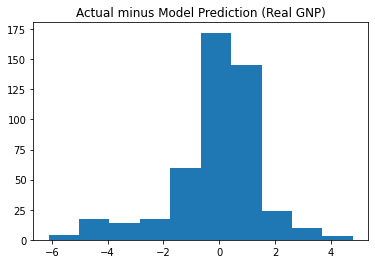

Differences in actual vs. forecaster average prediction (Real GNP)
Mean: 0.7461467851527642
Median: 0.8447200000000001
Max: 6.23229
Min: -4.83796
Correlation Coef: 0.7261290675796293
RMSE: 1.7987498474175718


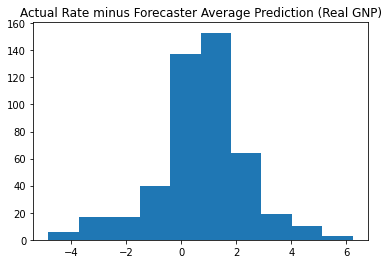

In [92]:
run_model(rgnp, "Real GNP", "LM", plot=True)

## Linear Regression Evaluation

In [95]:
evaluate("LM")

We decrease RMSE by 0.27228587265821685
We increase R-squared by 0.04751278154269382


# Random Forest Regression

### Unemployment

Differences in actual vs. model prediction (Unemployment)
Mean: -0.014756261630211287
Median: -7.105427357601002e-15
Max: 6.46908305
Min: -7.540749690000008
Correlation Coef: 0.9305346558458819
RMSE: 1.0099637912333324


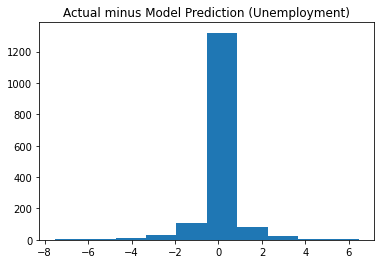

Differences in actual vs. forecaster average prediction (Unemployment)
Mean: -0.927036679770596
Median: -0.6187499999999999
Max: 7.28333333333333
Min: -8.475
Correlation Coef: 0.6223703505934035
RMSE: 2.3521156066892823


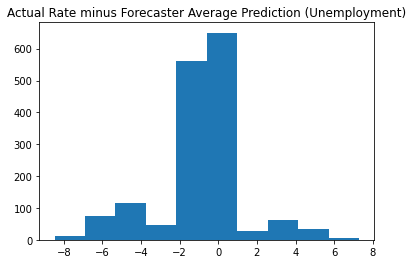

In [96]:
run_model(unemp, "Unemployment", "RF", plot = True)

### Real GDP

Differences in actual vs. model prediction (Real GDP)
Mean: -0.01608006618574017
Median: -0.0029124999999998735
Max: 6.271102299999997
Min: -7.439254555
Correlation Coef: 0.8656690561219095
RMSE: 0.9540375368636396


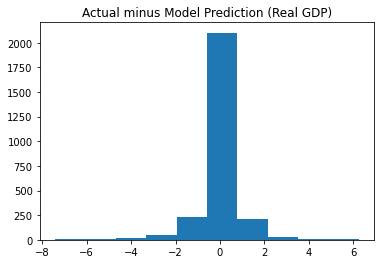

Differences in actual vs. forecaster average prediction (Real GDP)
Mean: -0.5016833731834279
Median: -0.22448999999999986
Max: 4.6814100000000005
Min: -8.82417
Correlation Coef: 0.49099374746379565
RMSE: 1.738230519261282


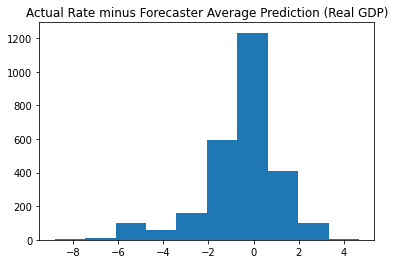

In [97]:
run_model(rgdp, "Real GDP", "RF", plot=True)

### Core CPE

Differences in actual vs. model prediction (Core PCE)
Mean: -0.010891497712617628
Median: -0.00487101457906558
Max: 6.938217756882324
Min: -7.520478857500007
Correlation Coef: 0.7557578966992166
RMSE: 0.7739566483970595


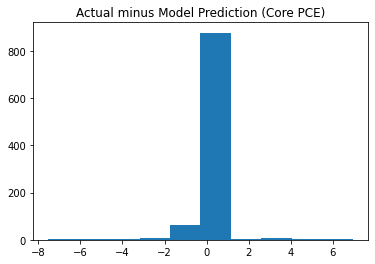

Differences in actual vs. forecaster average prediction (Core PCE)
Mean: -0.057051824546893094
Median: -0.1924743228105099
Max: 7.608333
Min: -2.65
Correlation Coef: -0.04452120446356747
RMSE: 1.2772863612158625


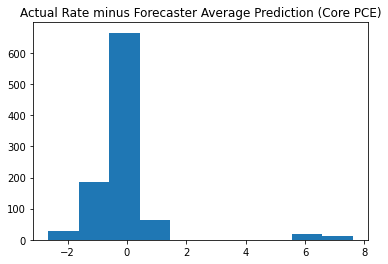

In [98]:
run_model(cpce, "Core PCE", "RF", plot=True)

### Core CPI

Differences in actual vs. model prediction (Core CPI)
Mean: 0.018667897246921594
Median: -0.007711757338618064
Max: 7.935167630869168
Min: -5.983640342646338
Correlation Coef: 0.6473939587408589
RMSE: 0.9784509162611379


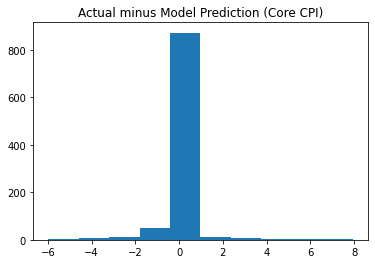

Differences in actual vs. forecaster average prediction (Core CPI)
Mean: -0.01767454758190156
Median: -0.11764099999999988
Max: 7.729433
Min: -8.629427473536666
Correlation Coef: 0.03776833640357241
RMSE: 1.4030688358253587


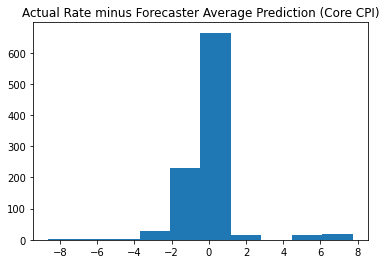

In [99]:
run_model(ccpi, "Core CPI", "RF", plot=True)

### Nominal GNP

Differences in actual vs. model prediction (Nominal GNP)
Mean: -0.0698944562258711
Median: -0.014018099999992373
Max: 3.5798198000000028
Min: -6.223417599999995
Correlation Coef: 0.892553127851153
RMSE: 0.9215949203735522


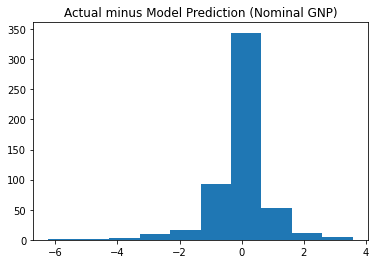

Differences in actual vs. forecaster average prediction (Nominal GNP)
Mean: 1.1021452065932849
Median: 0.8385509900989998
Max: 10.274149999999999
Min: -4.61285
Correlation Coef: 0.675624737953995
RMSE: 2.1765804640572437


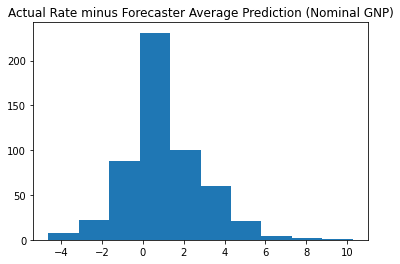

In [100]:
run_model(ngnp, "Nominal GNP", "RF", plot=True)

### Real GNP

Differences in actual vs. model prediction (Real GNP)
Mean: 0.002665560526617765
Median: 0.03261690000000872
Max: 3.8264485999999973
Min: -6.602354708333339
Correlation Coef: 0.8915529647370358
RMSE: 1.1152224128326984


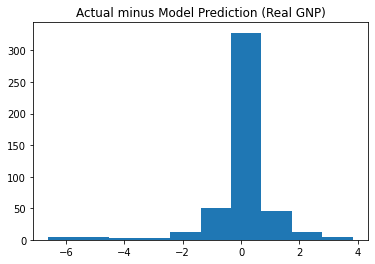

Differences in actual vs. forecaster average prediction (Real GNP)
Mean: 0.7653847722347342
Median: 0.8090600000000002
Max: 7.90641
Min: -4.93796
Correlation Coef: 0.7512422754939493
RMSE: 1.7965890089623433


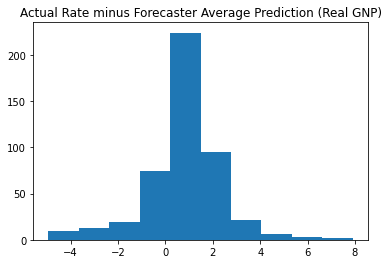

In [101]:
run_model(rgnp, "Real GNP", "RF", plot=True)

## Random Forest Evaluation

In [102]:
evaluate("RF")

We decrease RMSE by 0.8214505051625908
We increase R-squared by 0.39515713245749823


In [ ]:
evaluate("LM")

In [34]:
data, actual, pred = get_preds(unemp, "RF")
#plt.plot(actual)
#plt.plot(pred)
#plt.plot(forecaster)

In [35]:
data.head()

,FORECASTER ID,MAX,pred_average,pred_var,HIT,ACTUAL_CONF
13741,549,0.95,4.5375,0.026719,1.0,0.95
6521,456,0.40,10.0500,0.633750,0.0,0.30
7818,483,0.25,8.0950,1.623475,0.0,0.15
10595,572,0.38,6.6525,0.709869,0.0,0.25
7403,421,0.40,9.6125,0.215469,0.5,0.40


In [140]:
rgdp.head()

,Unnamed: 0,YEAR FORECAST MADE,QUARTER,YEAR BEING FORECAST,INDICATOR,FORECASTER ID,INDUSTRY,Year.ID.ForecastYear.Quarter,Indicator.Year.ID.ForecastYear.Quarter,BIN 1,...,ACTUAL_CONF,HIT,pred_average,pred_var,chicken,coffee,eggs,electricity,rice,unleadedGasoline
5016,5016,1992,1,1992,RealGDP,20,2.0,1992-20-1992-1,RealGDP-1992-20-1992-1,0.0,...,0.0,0.0,1.00,0.2500,0.862,2.662333,0.888,0.085,0.515333,1.061667
5017,5017,1992,1,1992,RealGDP,30,3.0,1992-30-1992-1,RealGDP-1992-30-1992-1,0.0,...,0.6,1.0,3.30,0.3600,0.862,2.662333,0.888,0.085,0.515333,1.061667
5018,5018,1992,1,1992,RealGDP,35,2.0,1992-35-1992-1,RealGDP-1992-35-1992-1,0.0,...,0.1,0.0,2.10,1.2400,0.862,2.662333,0.888,0.085,0.515333,1.061667
5019,5019,1992,1,1992,RealGDP,40,2.0,1992-40-1992-1,RealGDP-1992-40-1992-1,0.0,...,0.1,0.0,2.10,1.2400,0.862,2.662333,0.888,0.085,0.515333,1.061667
5020,5020,1992,1,1992,RealGDP,60,2.0,1992-60-1992-1,RealGDP-1992-60-1992-1,0.0,...,0.0,0.0,1.15,0.4275,0.862,2.662333,0.888,0.085,0.515333,1.061667


In [37]:
unemp.columns

Index(['YEAR FORECAST MADE', 'QUARTER', 'YEAR BEING FORECAST', 'INDICATOR',
       'FORECASTER ID', 'INDUSTRY', 'Year.ID.ForecastYear.Quarter',
       'Indicator.Year.ID.ForecastYear.Quarter', 'BIN 1', 'BIN 2', 'BIN 3',
       'BIN 4', 'BIN 5', 'BIN 6', 'BIN 7', 'BIN 8', 'BIN 9', 'BIN 10',
       'BIN 11', 'BIN 12', 'BIN 13', 'BIN 14', 'BIN 15', 'BIN 1 prob',
       'BIN 2 prob', 'BIN 3 prob', 'BIN 4 prob', 'BIN 5 prob', 'BIN 6 prob',
       'BIN 7 prob', 'BIN 8 prob', 'BIN 9 prob', 'BIN 10 prob', 'BIN 11 prob',
       'BIN 12 prob', 'BIN 13 prob', 'BIN 14 prob', 'BIN 15 prob',
       'BIN 1 midpoint', 'BIN 2 midpoint', 'BIN 3 midpoint', 'BIN 4 midpoint',
       'BIN 5 midpoint', 'BIN 6 midpoint', 'BIN 7 midpoint', 'BIN 8 midpoint',
       'BIN 9 midpoint', 'BIN 10 midpoint', 'BIN 11 midpoint',
       'BIN 12 midpoint', 'BIN 13 midpoint', 'BIN 14 midpoint',
       'BIN 15 midpoint', 'nbin', 'bin_value_sum', 'TDIST', 'actual',
       'ACTUAL_BIN', 'MAX', 'NUM_OF_MAX', 'ACTUAL_CONF', 'HI

In [42]:
unemp['YEAR BEING FORECAST'].value_counts()

2015    342
2014    341
2016    338
2013    338
2017    332
2018    319
2012    316
2019    273
2011    230
2020    191
2010    146
2021    112
2009     63
2022     39
Name: YEAR BEING FORECAST, dtype: int64

In [43]:
unemp['YEAR FORECAST MADE'].value_counts()

2012    344
2014    344
2013    340
2015    340
2011    336
2010    332
2016    328
2017    316
2018    292
2009    252
2019    156
Name: YEAR FORECAST MADE, dtype: int64

In [44]:
len(train[train['YEAR FORECAST MADE'] == train['YEAR BEING FORECAST']])

7090

In [45]:
len(train)

16217

In [46]:
len(unemp)

3380

In [54]:
same_unemp = unemp[unemp['YEAR FORECAST MADE'] == unemp['YEAR BEING FORECAST']]
len(unemp[unemp['YEAR FORECAST MADE'] == unemp['YEAR BEING FORECAST']])

845

In [48]:
len(rgdp[rgdp['YEAR FORECAST MADE'] == rgdp['YEAR BEING FORECAST']])

2188

In [49]:
len(rgnp[rgnp['YEAR FORECAST MADE'] == rgnp['YEAR BEING FORECAST']])

584

In [50]:
len(ngnp[ngnp['YEAR FORECAST MADE'] == ngnp['YEAR BEING FORECAST']])

1343

In [51]:
len(ccpi[ccpi['YEAR FORECAST MADE'] == ccpi['YEAR BEING FORECAST']])

1065

In [53]:
len(cpce[cpce['YEAR FORECAST MADE'] == cpce['YEAR BEING FORECAST']])

1065

In [55]:
same_unemp['YEAR FORECAST MADE'].value_counts()

2012    86
2014    86
2013    85
2015    85
2011    84
2010    83
2016    82
2017    79
2018    73
2009    63
2019    39
Name: YEAR FORECAST MADE, dtype: int64

In [60]:
same_unemp.head()

,YEAR FORECAST MADE,QUARTER,YEAR BEING FORECAST,INDICATOR,FORECASTER ID,INDUSTRY,Year.ID.ForecastYear.Quarter,Indicator.Year.ID.ForecastYear.Quarter,BIN 1,BIN 2,...,bin_value_sum,TDIST,actual,ACTUAL_BIN,MAX,NUM_OF_MAX,ACTUAL_CONF,HIT,pred_average,pred_var
6155,2009,2,2009,Unemployment,527,2.0,2009-527-2009-2,Unemployment-2009-527-2009-2,0.0,0.0,...,100.0,0.5,9.283333,4.0,0.60,1.0,0.60,1.0,9.4500,0.060000
6156,2009,2,2009,Unemployment,540,2.0,2009-540-2009-2,Unemployment-2009-540-2009-2,0.0,0.0,...,100.0,0.5,9.283333,4.0,0.40,2.0,0.40,0.5,8.8500,0.140000
6157,2009,2,2009,Unemployment,549,1.0,2009-549-2009-2,Unemployment-2009-549-2009-2,0.0,0.0,...,100.0,0.5,9.283333,4.0,0.55,1.0,0.55,1.0,9.4750,0.061875
6158,2009,2,2009,Unemployment,484,2.0,2009-484-2009-2,Unemployment-2009-484-2009-2,3.0,12.0,...,100.0,0.5,9.283333,4.0,0.27,1.0,0.27,1.0,9.2725,0.656369
6159,2009,2,2009,Unemployment,553,2.0,2009-553-2009-2,Unemployment-2009-553-2009-2,0.0,10.0,...,100.0,0.5,9.283333,4.0,0.45,1.0,0.40,0.0,9.5750,0.175625


In [109]:
unemp_rmse_pred, unemp_rmse_actual, unemp_r2_pred, unemp_r2_actual = run_model(
    unemp, "Unemployment", "LM", plot=False, ensemble=True)

In [110]:
unemp_rmse_actual - unemp_rmse_pred

1.0491184759479257

In [111]:
unemp_r2_pred - unemp_r2_actual

0.25611343804269215

In [124]:
evaluate_ensemble()

We decrease RMSE by 0.5338325372386963
We increase R-squared by 0.4304053407119052


([2.3416080943603585,
  1.6627716104937262,
  1.3240745882805094,
  1.305346609249318],
 [1.382992528364267,
  1.0771175569603986,
  1.0259959919392208,
  1.012364676165241],
 [0.8786517138306273,
  0.8323446252280846,
  0.6425793192352016,
  0.5740928158322827],
 [0.6246272023144769,
  0.5080912118052938,
  0.016969952331613452,
  0.056358744827191144])

In [125]:
evaluate("LM")

We decrease RMSE by 0.15873567060346927
We increase R-squared by 0.04726369341573762


([2.3113442019647414,
  1.705306140338677,
  1.2355382206690564,
  1.3563743939599835],
 [2.056148476796986,
  1.5586697822154143,
  1.1608161600555118,
  1.1979858554506688],
 [0.6826577096587956,
  0.5422737130999501,
  0.0458557847512643,
  0.08986243257026803],
 [0.6605729119468742,
  0.4687038952560699,
  0.010476476102130016,
  0.031841583112253394])

In [126]:
evaluate("RF")

We decrease RMSE by 0.7458386692413521
We increase R-squared by 0.50247724612209


([2.3524102149564654,
  1.7094437523866137,
  1.2014412487830393,
  1.3802225042086604],
 [1.0148626630897644,
  0.9230582900617738,
  0.7986159878844615,
  0.923626102333371],
 [0.931122022868016,
  0.8683358893502803,
  0.6983604405268484,
  0.7066816589319511],
 [0.62579464949432,
  0.4800946410292857,
  0.002585950765469872,
  0.08611578589966028])

In [144]:
evaluate("LM")

Unemployment
1.8668689758207033 2.3748434316998623 0.7495820497607695 0.6296739939988717

Real GDP
1.228441318743601 1.6752599365216008 0.7495971573263694 0.500716675772565

Core PCE
1.055243454553904 1.1698846296499692 0.2374051768414037 -0.018527530804493895

Core CPI
1.2542210436250216 1.3605638202730288 0.34070905685681746 0.17596549843128428

We decrease RMSE by 0.2939442563503078
We increase R-squared by 0.19736620084678325


In [145]:
evaluate("RF")

Unemployment
0.5484955958561268 2.3320533298192307 0.9806810425416564 0.650035617762591

Real GDP
0.39897759550694295 1.6771332899274278 0.9766701052433822 0.499339689280467

Core PCE
0.34155293107005597 1.3662775646996523 0.9646439839220473 -0.002690306475078272

Core CPI
0.4103789225040169 1.4717790153760109 0.9542985495334922 0.032586812893465385

We decrease RMSE by 1.2869595387212946
We increase R-squared by 0.6742554669447832


In [159]:
evaluate("XG")

Unemployment
0.6950908260135282 2.3758819257627484 0.9692063450905944 0.6232218425283859

Real GDP
0.4001125279709533 1.6881626872535254 0.9762844252525346 0.4795307851777331

Core PCE
0.3245479955421632 1.2203739462941754 0.9584886265965664 -0.01718404901616951

Core CPI
0.4799464063986424 1.358176450735756 0.92719512928312 0.032331200840695185

We decrease RMSE by 1.1857243135302296
We increase R-squared by 0.6783186866730426


In [148]:
evaluate_ensemble()

Unemployment
1.1331673710691266 2.5077216301010092 0.9282698363534396 0.6035467657870857

Real GDP
0.7192356042867811 1.7014777466201554 0.9349994090620644 0.5117223452042425

Core PCE
0.7603190218042571 1.4166699887089746 0.9006887491578545 -0.0015825588906905551

Core CPI
0.66357161794116 1.3036490575518254 0.8732127218272376 0.03225630346877038

We decrease RMSE by 0.9133062019701599
We increase R-squared by 0.622806965207797


In [161]:
evaluate_ensemble()

Unemployment
0.8570142174409868 2.348598710656992 0.9555990292380939 0.6314976054578582

Real GDP
0.5307059697421277 1.6358429414995002 0.9623223392734153 0.5109202818456954

Core PCE
0.5093842787229268 1.1997658363109074 0.9241407133248366 0.013448498215915315

Core CPI
0.5242649532255195 1.2650990301000051 0.9342790582423316 0.09162254607615927

We decrease RMSE by 1.006984274858961
We increase R-squared by 0.6322130521207623
